# Import

In [241]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [242]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [243]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_1_layout import layout
# from line_plot_error_1_layout import layout
from util import *

## Set condition

In [244]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [245]:
data_type = "AgNews"
vectorize_types = ["doc2vec", "sentenceBERT"]

# Read data

In [246]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [247]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [248]:
vector_dims = {"doc2vec": config["vectorize"]["doc2vec"]["dims"], "sentenceBERT": [384]}
model_nums = config["clustering"]["gmm"]["max_model_num"]
vector_model_num = config["vectorize"]["doc2vec"]["max_model_num"]
normalizations = ["centralized", "normalized"]
covariance_type = "spherical"

In [249]:
stats_vals = ["mi"]

In [250]:
def get_stats_vals(
    data_type, vectorize_type, covariance_type, normalizations, stats_vals
):
    # データ型定義
    stats = {
        stats_val: {
            normalization: {
                model_num: pd.DataFrame for model_num in range(model_nums)
            }
            for normalization in normalizations
        }
        for stats_val in stats_vals
    }

    # データ取得
    for stats_val in stats_vals:
        for normalization in normalizations:
            for model_num in range(model_nums):
                stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{normalization}/{covariance_type}/{model_num}.csv"
                df = pd.read_csv(stats_path, index_col=0)
                stats[stats_val][normalization][model_num] = df.loc[:, stats_val]
    return stats

In [251]:
stats = {
    vectorize_type: get_stats_vals(
        data_type, vectorize_type, covariance_type, normalizations, stats_vals
    )
    for vectorize_type in vectorize_types
}

In [252]:
stats_const = {
    vectorize_type: get_stats_vals(
        data_type, vectorize_type, covariance_type, normalizations, stats_vals
    )
    for vectorize_type in vectorize_types
}

In [253]:
lda_mi = pd.read_csv(f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0)

In [254]:
describe_lda_mi, _ = get_describe(lda_mi, axis=0)

# Data shaping

In [255]:
def make_stats_df(stats, normalizations, stats_vals):
    stats_df = {
        stats_val: {normalization: pd.DataFrame() for normalization in normalizations}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for normalization in normalizations:
            # model_numについて取得データstatsを結合
            stats_df[stats_val][normalization] = pd.concat(
                stats[stats_val][normalization], axis=1
            )
    return stats_df

In [256]:
stats_df = {
    vectorize_type: make_stats_df(stats[vectorize_type], normalizations, stats_vals)
    for vectorize_type in vectorize_types
}

In [257]:
def make_describe(stats_df, normalization, stats_vals):
    describe = {
        stats_val: {normalization: dict() for normalization in normalizations}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for normalization in normalizations:
            describe[stats_val][normalization], describe_keys = get_describe(
                stats_df[stats_val][normalization], axis=1
            )
    return describe, describe_keys

In [258]:
describe = {vectorize_type: {} for vectorize_type in vectorize_types}
for vectorize_type in vectorize_types:
    _describe, describe_keys = make_describe(stats_df[vectorize_type], normalizations, stats_vals)
    describe[vectorize_type] = _describe

In [259]:
def make_data(describe, normalizations, stats_vals, describe_keys):
    data = {
        stats_val: {describe_key: pd.DataFrame() for describe_key in describe_keys}
        for stats_val in stats_vals
    }
    for stats_val in stats_vals:
        for describe_key in describe_keys:
            # normalizationについてデータを結合
            _data = {
                normalization: describe[stats_val][normalization][describe_key]
                for normalization in normalizations
            }
            data[stats_val][describe_key] = pd.concat(_data, axis=1)
    return data

In [260]:
data = {
    vectorize_type: make_data(
        describe[vectorize_type], normalizations, stats_vals, describe_keys
    )
    for vectorize_type in vectorize_types
}

In [261]:
title = f"{data_type}    ({vectorize_type})"
xlabel = "埋め込み次元"
ylabel = "AMI"
yticks = np.arange(0, 1.1, 0.1)
# path = fig_path

In [262]:
cycler = {
    "color":
    [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ],
}

In [263]:
line_labels = {
    "centralized": "正規化なし",
    "normalized": "正規化あり"
}

In [264]:
vectorize_labels = {
    "doc2vec": "",
    "sentenceBERT": "SBERT"
}

In [266]:
data["doc2vec"]["mi"]["mean"]

,centralized,normalized
2,0.260789,0.230873
4,0.400907,0.402292
6,0.426131,0.454490
8,0.407455,0.454906
10,0.379061,0.438973
20,0.169183,0.265781
40,0.006142,0.019857
80,0.002994,0.002121
160,0.002960,0.004118


In [265]:
data["doc2vec"]["mi"]["std"]

,centralized,normalized
2,0.002285,0.003579
4,0.001029,0.009978
6,0.000145,0.000120
8,0.000376,0.000047
10,0.000165,0.000210
20,0.003148,0.001968
40,0.000274,0.001519
80,0.000190,0.000359
160,0.000177,0.000224


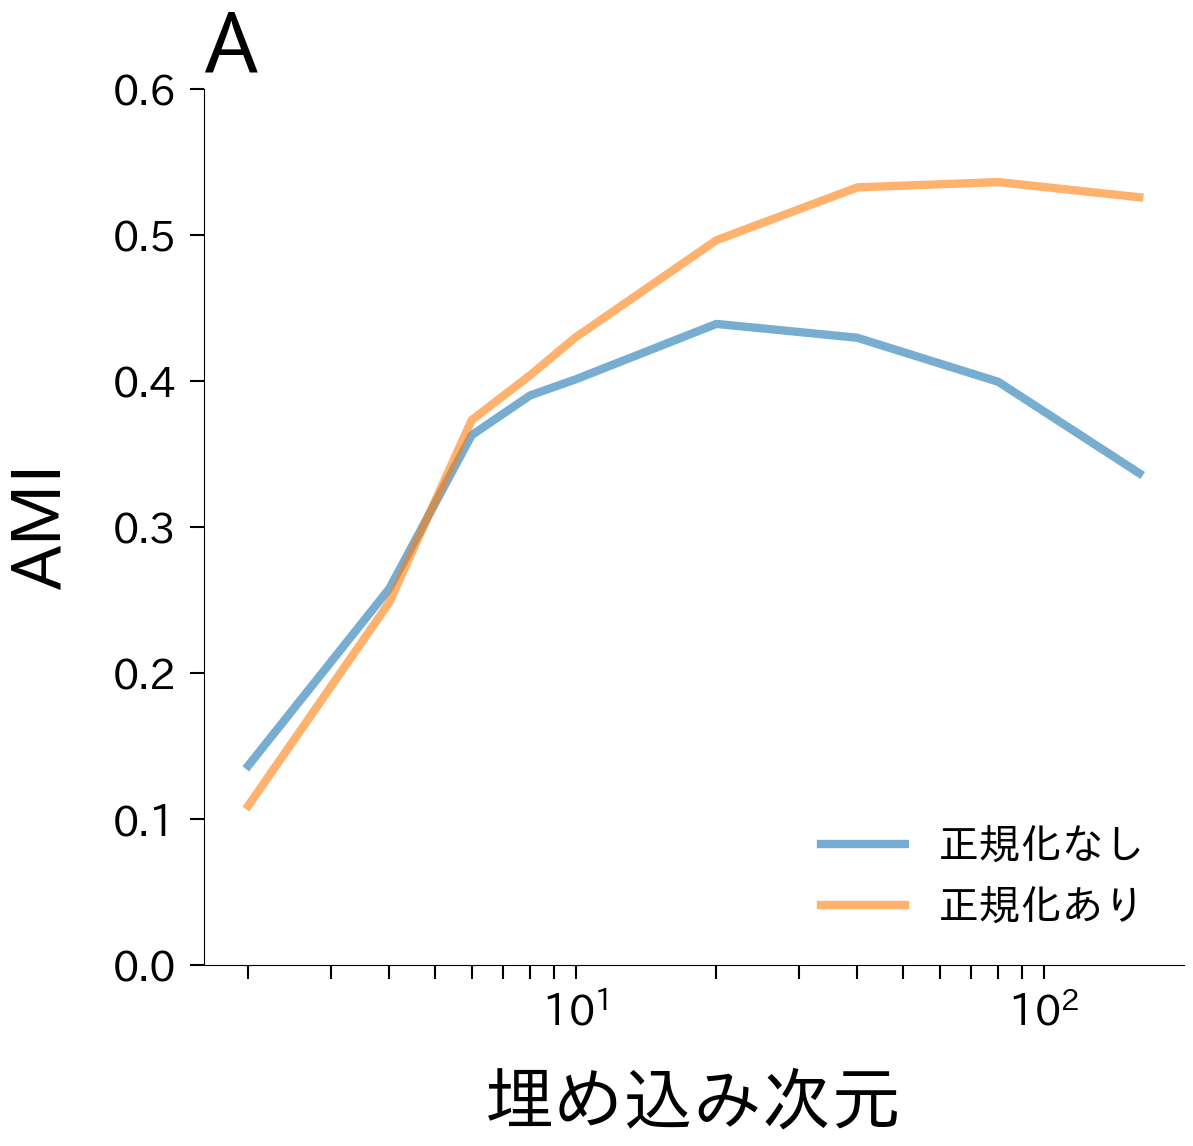

In [132]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)
fig.subplots_adjust(left=0.2, bottom=0.15)
fig_path = f"../data/figure/{data_type}/NormalCentral{data_type}.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for column in data["doc2vec"]["mi"]["mean"].columns:
    ax.plot(
        data["doc2vec"]["mi"]["mean"].index.to_numpy(),
        data["doc2vec"]["mi"]["mean"].loc[:, column].to_numpy(),
        label=f"{line_labels[column]}",
        alpha=0.6,
        linewidth=6.0,
    )

# for i, normalization in enumerate(normalizations):
#     ax.axhline(
#         y=data["sentenceBERT"]["mi"]["mean"].loc[384, normalization],
#         label=f"SBERT {line_labels[normalization]}",
#         color=cycler["color"][i + 3],
#         **layout["plot"]
#     )
ax.set_title("A", fontsize=60, loc="left")

ax.tick_params(which="both", width=1.5, length=8, size=10, direction="out")
ax.xaxis.set_tick_params(labelsize=30, pad=10)
ax.yaxis.set_tick_params(labelsize=30, pad=10)

ax.set_xlabel(xlabel, fontsize=50, labelpad=27, fontweight="black")
ax.set_ylabel(ylabel, fontsize=50, labelpad=27, fontweight="black")
ax.set_yticks(np.arange(0, 0.7, 0.1))
ax.legend(fontsize=30, framealpha=0, loc="lower right")

fig.savefig(make_filepath(fig_path))

## Figure sub

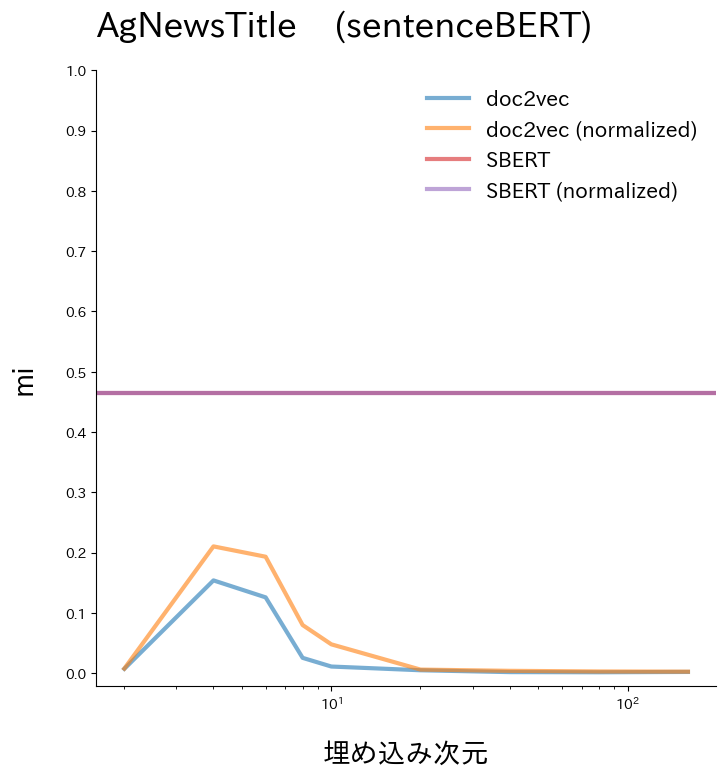

In [26]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/NormalCentral.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for column in data["doc2vec"]["mi"]["mean"].columns:
    ax.plot(
        data["doc2vec"]["mi"]["mean"].index.to_numpy(),
        data["doc2vec"]["mi"]["mean"].loc[:, column].to_numpy(),
        label=f"doc2vec {line_labels[column]}",
        **layout["plot"],
    )

for i, normalization in enumerate(normalizations):
    ax.axhline(
        y=data["sentenceBERT"]["mi"]["mean"].loc[384, normalization],
        label=f"SBERT {line_labels[normalization]}",
        color=cycler["color"][i + 3],
        **layout["plot"]
    )

ax.set_title(title, **layout["title"])

ax.set_xlabel(xlabel, **layout["label"])
ax.set_ylabel(ylabel, **layout["label"])
ax.set_yticks(ticks=yticks, **layout["ticks"])
ax.legend(**layout["legend"])

fig.savefig(make_filepath(fig_path))

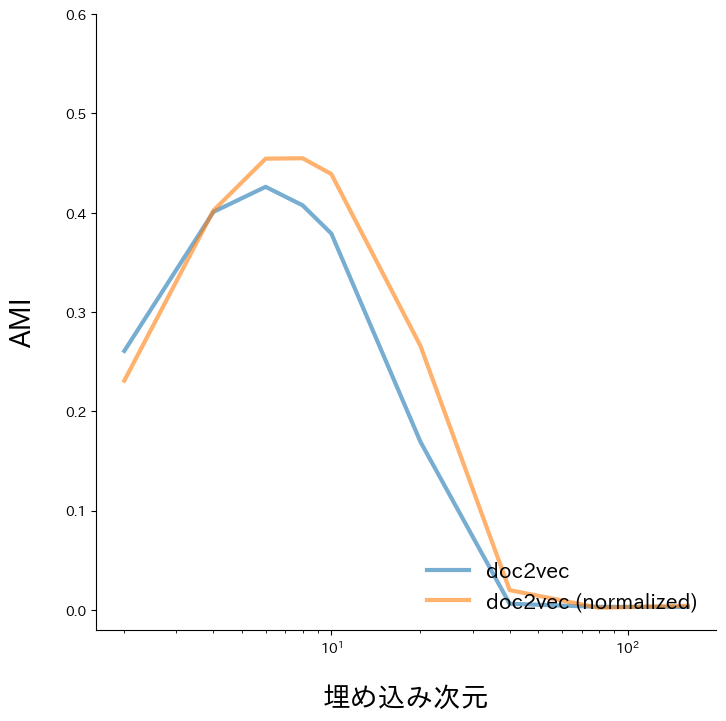

In [83]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/NormalCentral{data_type}.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for column in data["doc2vec"]["mi"]["mean"].columns:
    ax.plot(
        data["doc2vec"]["mi"]["mean"].index.to_numpy(),
        data["doc2vec"]["mi"]["mean"].loc[:, column].to_numpy(),
        label=f"doc2vec {line_labels[column]}",
        **layout["plot"],
    )

# for i, normalization in enumerate(normalizations):
#     ax.axhline(
#         y=data["sentenceBERT"]["mi"]["mean"].loc[384, normalization],
#         label=f"SBERT {line_labels[normalization]}",
#         color=cycler["color"][i + 3],
#         **layout["plot"]
#     )

# ax.set_title(title, **layout["title"])

ax.set_xlabel(xlabel, **layout["label"])
ax.set_ylabel(ylabel, **layout["label"])
ax.set_yticks(np.arange(0, 0.7, 0.1), **layout["ticks"])
ax.legend(**layout["legend"])

fig.savefig(make_filepath(fig_path))

In [92]:
error_low = {
    vectorize_type: data[vectorize_type]["mi"]["std"]
    for vectorize_type in vectorize_types
}
error_upper = {
    vectorize_type: data[vectorize_type]["mi"]["std"]
    for vectorize_type in vectorize_types
}


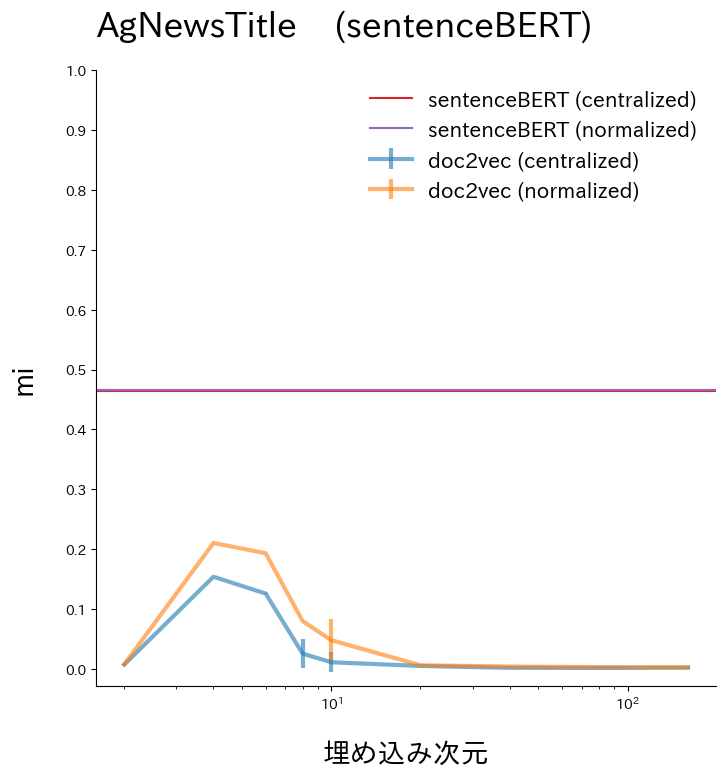

In [93]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/stats/mi.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for column in data["doc2vec"]["mi"]["mean"].columns:
    ax.errorbar(
        x=data["doc2vec"]["mi"]["mean"].index.to_numpy(),
        y=data["doc2vec"]["mi"]["mean"].loc[:, column].to_numpy(),
        label=f"doc2vec ({column})",
        yerr=np.stack(
                [
                    error_low["doc2vec"].loc[:, column].to_numpy(),
                    error_upper["doc2vec"].loc[:, column].to_numpy(),
                ],
            ),

        **layout["plot"],
    )

for i, normalization in enumerate(normalizations):
    ax.axhline(
        y=data["sentenceBERT"]["mi"]["mean"].loc[384, normalization],
        label=f"sentenceBERT ({normalization})",
        color=cycler["color"][i + 3],
#         **layout["plot"]
    )

ax.set_title(title, **layout["title"])

ax.set_xlabel(xlabel, **layout["label"])
ax.set_ylabel(ylabel, **layout["label"])
ax.set_yticks(ticks=yticks, **layout["ticks"])
ax.legend(**layout["legend"])

fig.savefig(make_filepath(fig_path))

# Chart

In [55]:
chart_data = data["doc2vec"]["mi"]["mean"]
for normalization in normalizations:
    chart_data[f"sentenceBERT_{normalization}"] = data["sentenceBERT"]["mi"][
        "mean"
    ].loc[384, normalization]

In [56]:
chart_data.style.highlight_max(axis=0)

,centralized,normalized,sentenceBERT_centralized,sentenceBERT_normalized
2,0.260789,0.230873,0.578525,0.582227
4,0.400907,0.402292,0.578525,0.582227
6,0.426131,0.454490,0.578525,0.582227
8,0.407455,0.454906,0.578525,0.582227
10,0.379061,0.438973,0.578525,0.582227
20,0.169183,0.265781,0.578525,0.582227
40,0.006142,0.019857,0.578525,0.582227
80,0.002994,0.002121,0.578525,0.582227
160,0.002960,0.004118,0.578525,0.582227
